# Bведение

Данный ноутбук основан на посте https://quantrum.me/875-parnyj-trejding-opisanie-strategii-na-python/

Стратегия парного трейдинга очень популярна на рынке. Она основана на чистой статистике, что делает ее привлекательной для алгоритмической торговли. Общий смысл сводится к нескольким шагам: найти пару, проверить ее поведение, определить границы входа в позицию и направление (лонг/шорт).

Пары ищут с помощью корреляции, но корреляция в чистом виде может сослужить плохую службу. Спред пар должен быть стационарным и обладать коинтегрированностью.

В статье рассмотрены:

Введение в корреляцию/коинтеграцию на простом примере.
Корреляция без коинтеграции.
Коинтеграция без корреляции.

Основные понятия
Временной ряд — статистические данные исследуемого процесса собранные в разные моменты времени.

Корреляция — статистическая взаимосвязь двух и более случайных величин. В нашем случае временных рядов.

Коинтеграция — свойство нескольких нестационарных временных рядов, заключающееся в существовании некоторой их стационарной линейной комбинации.

Стационарность — свойство процесса не менять свои характеристики со временем.

P-значение — величина используемая при тестировании статистических гипотез.

Простыми словами: две акции будут коинтегрированы, когда спред разницы их истории цен будет находиться в пределах фиксированных границ и не будет обладать трендом.

In [1]:
## Пример на сгенерированных данных

Для начала сгенерируем два датасета.
Второй - это то же самое что и первый, сдвинутый на некоторую величину и с добавленным случайным шумом.


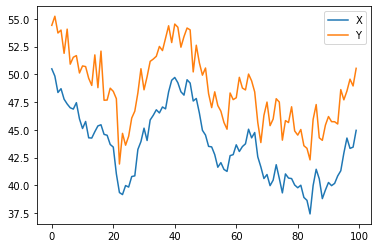

In [2]:
import numpy as np
import pandas as pd
import statsmodels
from statsmodels.tsa.stattools import coint,adfuller
import seaborn
import matplotlib.pyplot as plt

 
# устанавливаем зерно для повторимости случайных чисел
np.random.seed(107)
 
X_returns = np.random.normal(0, 1, 100) # генерируем историю доходности
X = pd.Series(np.cumsum(X_returns), name='X') + 50 # суммируем и смещаем на произвольную величину
 
some_noise = np.random.normal(0, 1, 100) # немного шума для второго ряда
Y = X + 5 + some_noise
Y.name = 'Y'
pd.concat([X, Y], axis=1).plot() # рисуем оба ряда


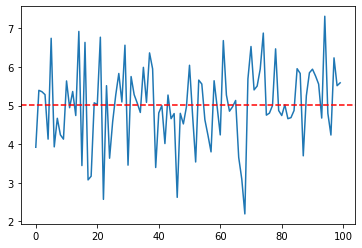

In [3]:
(Y-X).plot() # рисуем спрэд
plt.axhline((Y-X).mean(), color='red', linestyle='--') # добавляем среднее

Проверив значения коинтеграции и корреляции, видим что спред пары стационарен, p-значение рядом с нулем, и имеет высокую корреляцию около 95%. Код для получения значений оценки ниже:

In [4]:

def check_coint_corr(X, Y):
    # проверим стационарность двух рядов
    score, pvalue, _ = coint(X,Y)
    # проверим корреляцию двух рядов
    corr = X.corr(Y)
    print("p-значение: %.4f" % pvalue, "корреляция: %s" % corr)
check_coint_corr(X, Y)

p-значение: 0.0000 корреляция: 0.9497090646385932


Дополнительно проведем тест Дики-Фуллера:
    Он показывает, есть ли  зависимость от времени (тренд) внутри самой серии.
    Если серия стационарна, полученное значение должно быть меньше чем critical value  (1% 5% или 10%- выбирать вам)

In [5]:
def dft(X):
    """
    X- pandas series.
    """
    result = adfuller(X)
    print(f'Checking {X.name} for stationarity')
    score = result[0]
    pvalue = result[1]
    crit = result[4]
    print(f'score is {score}')
    print (f'p-value is {pvalue}')
    print (f'critical values are {crit}')

In [6]:
dft(X)


Checking X for stationarity
score is -2.303029214049719
p-value is 0.17099285094671968
critical values are {'1%': -3.498198082189098, '5%': -2.891208211860468, '10%': -2.5825959973472097}


В данном случае мы не можем сказать, что серия стационарна (score > critical value для любого доверительного интервала).

Теперь проверим разницу X-Y:


In [7]:
dft(X-Y)


Checking None for stationarity
score is -10.724034324619938
p-value is 3.0982156802035054e-19
critical values are {'1%': -3.498198082189098, '5%': -2.891208211860468, '10%': -2.5825959973472097}


В данном случае (как и ожидалось) разница двух рядов стационарна.

Однако, есть случаи, когда ряды имеют высокую корреляцию без коинтеграции. Пара с таким свойством не подходит для парного трейдинга. Для изучения сформируем два независимых произвольных времянных ряда:

p-значение: 0.8816 корреляция: 0.9931343801275687


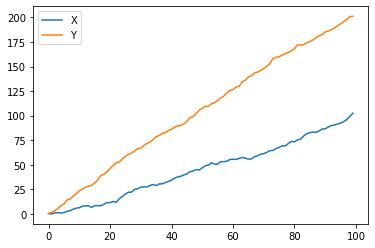

In [8]:
X_returns = np.random.normal(1, 1, 100)
Y_returns = np.random.normal(2, 1, 100)
X_diverging = pd.Series(np.cumsum(X_returns), name='X')
Y_diverging = pd.Series(np.cumsum(Y_returns), name='Y')
pd.concat([X_diverging, Y_diverging], axis=1).plot()
 
check_coint_corr(X_diverging, Y_diverging)

И нарисуем спред:

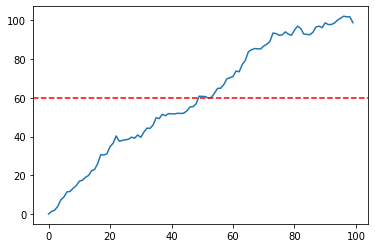

In [9]:
(Y_diverging-X_diverging).plot() # рисуем спрэд
plt.axhline((Y_diverging-X_diverging).mean(), color='red', linestyle='--') # добавляем среднее

Видим, что оба ряда имеют высокую корреляцию около 99% и проваливают тест на коинтеграцию с p-значением 0.881 (рядом с единицей). Мы видим, что спред имеет тенденцию роста со временем.

Так же проведем тест Дики-фуллера на одной из переменных и на их разнице:

In [10]:
dft(X_diverging)


Checking X for stationarity
score is 2.04915366037777
p-value is 0.9987335147618978
critical values are {'1%': -3.498198082189098, '5%': -2.891208211860468, '10%': -2.5825959973472097}


Серия не стационарна

In [11]:
dft(Y_diverging-X_diverging)


Checking None for stationarity
score is -2.619137569616801
p-value is 0.08910607539960957
critical values are {'1%': -3.498198082189098, '5%': -2.891208211860468, '10%': -2.5825959973472097}


То же самое можно сказать о разнице: если мы сравним с доверительным интервалом хотя бы 5% ( это означает что есть 5% вероятность того что полученные результаты случайны)- увидим что разница имеет тренд- что опять же не есть хорошо.

## Реальный пример

В данном примере мы возьмем две случайные акции, и проведем такой же визуальный анализ как показано выше.

In [12]:
#importing the libraries
import pandas as pd
import sys
sys.path.append('../src/data')
import ClickhouseHelper as chh

Скачаем минутные данные по ETF с начала 2020 года:

    
Кстати, ETF я использую исключительно для примера- размер получаемого датафрейма самый маленький.
В дальнейшем подобный подход будем использовать на акциях.

In [13]:
df=chh.query_data_by_time(
    channels_list=[],
    startTime=None,
    endTime=None,
    days_span=360,    
    server_ip="192.168.1.128",
    table_name="minutes",
    instrument_type="Etf",
    data_freq="day",
)

In [14]:
df.shape

(4947, 12)

In [15]:
df.columns

Index(['uniq(time)', 'count()', 'ticker', 'type', 'currency', 'name', 'day',
       'o', 'h', 'l', 'c', 'v'],
      dtype='object')

In [16]:
df.tail()

,uniq(time),count(),ticker,type,currency,name,day,o,h,l,c,v
4942,65,65,FXDE,Etf,RUB,Акции немецких компаний,2019-04-16,2056.0,2069.0,2056.0,2064.5,518
4943,69,69,FXRB,Etf,RUB,Еврооблигации российских компаний (RUB),2019-04-16,1525.0,1530.0,1524.0,1527.0,1353
4944,48,48,VTBB,Etf,RUB,ВТБ VTBB,2019-04-16,1018.8,1019.9,1017.9,1019.1,1956
4945,9,9,RUSB,Etf,RUB,Долларовые еврооблигации российских эмитентов,2019-04-16,1652.0,1654.0,1652.0,1654.0,190
4946,139,139,FXCN,Etf,RUB,Акции китайских компаний,2019-04-16,2752.0,2776.0,2746.0,2756.0,1083


In [17]:
# отфильтруем только по рублевым ETF
df=df[df.currency=='RUB']

In [18]:
# опять же для примера- нарисуем графики ETF vs Time

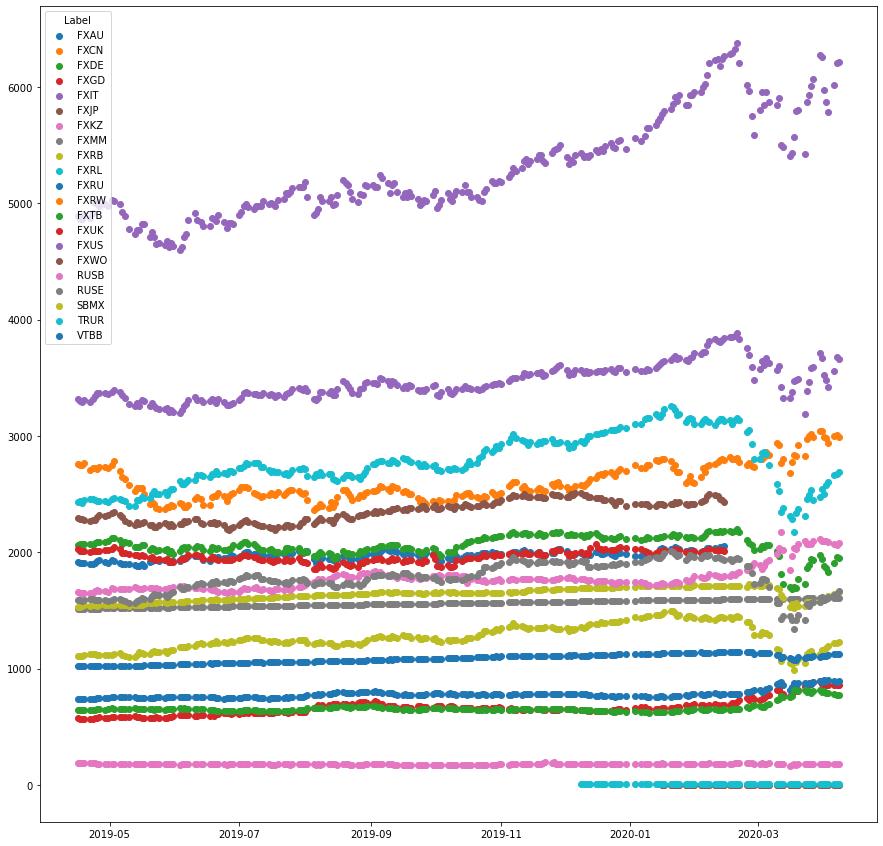

In [19]:
fig, ax = plt.subplots(figsize=(15,15))

for n, grp in df.groupby('ticker'):
    ax.scatter(x = "day", y = "c", data=grp, label=n)
ax.legend(title="Label")

plt.show()

Видим, что по коричневой и красным кривым ( FXUK, FXWO данные почему то скачались только до середины февраля.)

In [20]:
#Проверим длину ( количество значений) по каждому из ETF.
#Для анализа критичным является то, что при сравнении и расчете коинтеграции и корелляции длина временных рядов должна быть одинаковой.
all_lengths=[]
for etf in df.ticker.unique():
    print(f'shape of ETF {etf} {df[df.ticker==etf].name.unique()[0]} is: {df[df.ticker==etf].shape[0]}')
    
    all_lengths.append(df[df.ticker==etf].shape[0])

shape of ETF FXRU Еврооблигации российских компаний (USD) is: 247
shape of ETF TRUR Вечный портфель RUB is: 82
shape of ETF RUSE Акции российских компаний, входящие в индекс РТС is: 247
shape of ETF FXDE Акции немецких компаний is: 247
shape of ETF FXRB Еврооблигации российских компаний (RUB) is: 247
shape of ETF FXCN Акции китайских компаний is: 247
shape of ETF VTBB ВТБ VTBB is: 247
shape of ETF SBMX Сбербанк SBMX is: 247
shape of ETF FXWO FinEx FXWO is: 58
shape of ETF RUSB Долларовые еврооблигации российских эмитентов is: 247
shape of ETF FXRW FinEx FXRW is: 58
shape of ETF FXGD Золото is: 247
shape of ETF FXIT Акции компаний IT-сектора США is: 247
shape of ETF FXRL Акции российских компаний is: 247
shape of ETF FXKZ Акции казахстанских компаний is: 247
shape of ETF FXMM Казначейские облигации США is: 247
shape of ETF FXTB Казначейские облигации США (USD) is: 247
shape of ETF FXUS Акции американских компаний is: 247
shape of ETF FXUK Акции английских компаний is: 211
shape of ETF F

In [46]:
length_limit = int(np.percentile(all_lengths, 10))

In [47]:
length_limit

82

In [48]:
#keeping only tickers with len>len_limit:
for etf in df.ticker.unique():
    if df[df.ticker==etf].shape[0]<=length_limit:
        df = df[df.ticker != etf]


In [49]:
def get_performance(a):
    """
    Конвертируем историю в относительные величины
    
    """
    a=a.values
    return np.insert(np.cumsum(np.diff(a) / a[:-1] * 100.), 0, 0)

In [50]:
#Готовим данные для анализа: рассчитываем кумулятивную сумму дельт ( в % роста или падения от предыдущего дня)
df['c_cumsum']=df.groupby('ticker')['c'].transform(get_performance)
df['o_cumsum']=df.groupby('ticker')['o'].transform(get_performance)


C:\Users\SParkhonyuk\AppData\Local\Continuum\anaconda3\envs\DL_py37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\SParkhonyuk\AppData\Local\Continuum\anaconda3\envs\DL_py37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [51]:
# проверяем коинтеграцию и удаляем стационарные ряды
for ticker in df.ticker.unique():
    result = adfuller(df[df.ticker==ticker].c_cumsum.values)
    score = result[0]
    pvalue = result[1]
    crit = result[4]
    if score<crit['1%']: 
        print(f'ticker {ticker} is cointegrated. Deleting it.')
        df=df[df.ticker!=ticker]

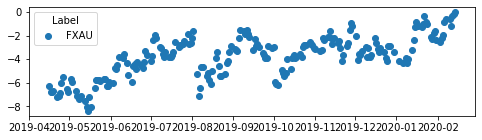

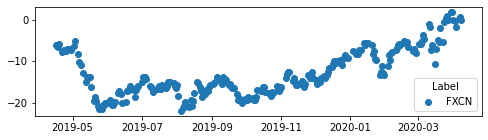

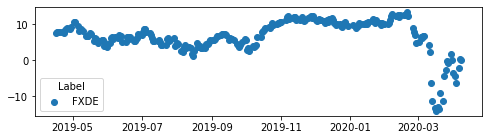

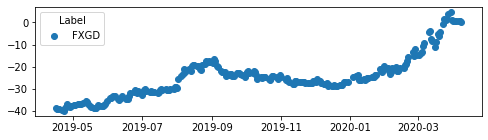

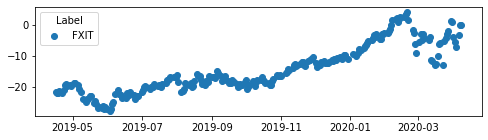

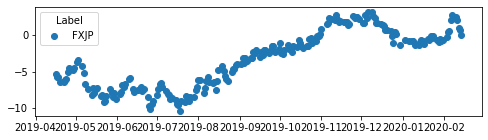

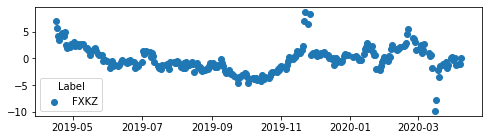

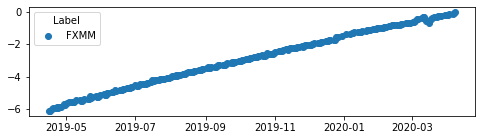

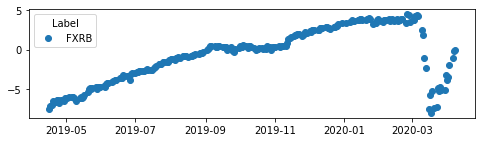

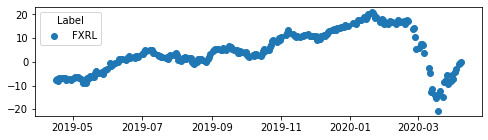

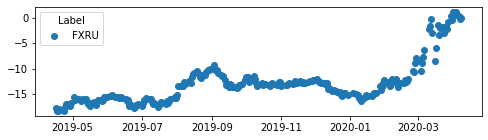

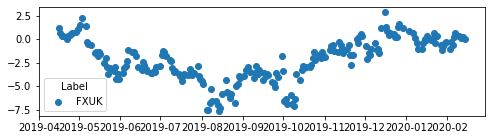

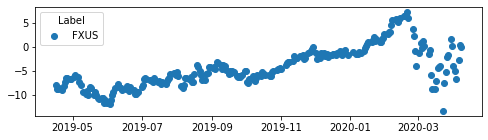

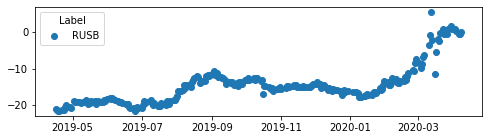

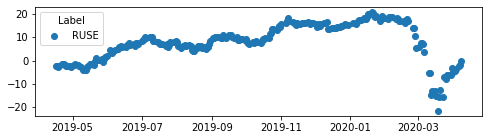

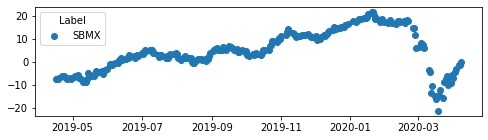

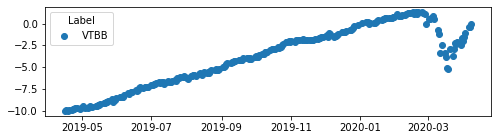

In [52]:


for n, grp in df.groupby('ticker'):
    fig, ax = plt.subplots(figsize=(8,2))
    ax.scatter(x = "day", y = "c_cumsum", data=grp, label=n)
    ax.legend(title="Label")
    plt.show()



In [53]:
#let's pivot table for simplicity
c_cumsum=df.pivot(index='day',columns='ticker',values='c_cumsum')
o_cumsum=df.pivot(index='day',columns='ticker',values='o_cumsum')

Следующий шаг- выберем случайно две колонки и построим их значения, так же значения их разницы.


p-значение: 0.1363 корреляция: 0.7536929901402631


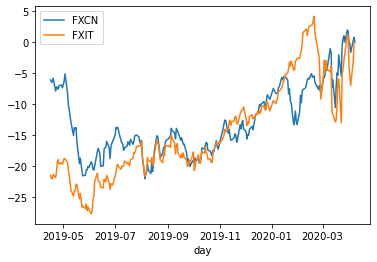

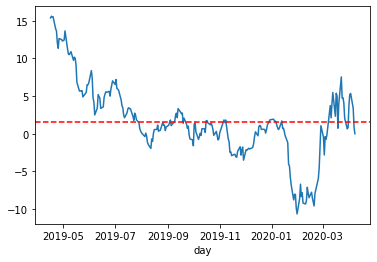

In [58]:
FXCN=c_cumsum.FXCN
FXIT=c_cumsum.FXIT
pd.concat([FXCN, FXIT], axis=1).plot()
 
check_coint_corr(FXCN, FXIT)

plt.show()
plt.figure()
(FXCN-FXIT).plot() # рисуем спрэд
plt.axhline((FXCN-FXIT).mean(), color='red', linestyle='--') # добавляем среднее
plt.show()

Видим, что оба ряда имеют низкую корреляцию около 10% и проваливают тест на коинтеграцию с p-значением 0.91 (рядом с единицей). Мы видим, что спред имеет временную зависимость.

Проведем тест Дики-Фуллера:
    

In [59]:
dft(FXCN)

Checking FXCN for stationarity
score is -0.6421254083863188
p-value is 0.8611765429767559
critical values are {'1%': -3.4583663275730476, '5%': -2.8738660999177132, '10%': -2.5733390785693766}


Серия не стационарна

In [60]:
dft(FXCN-FXIT)

Checking None for stationarity
score is -2.743884680229095
p-value is 0.06674725454420141
critical values are {'1%': -3.457664132155201, '5%': -2.8735585105960224, '10%': -2.5731749894132916}


Аналогично, данная серия не стационарна ( на горизонте 12-ти месяцев, и использовать ее нельзя)

In [61]:
## Автоматический подбор пар

Ну а сейчас - немного мяса. 
Давайте поищем пары среди ETF для парной торговли.


Данный тест проверяет времянной ряд (историю изменения цены) на стационарность (наличие коинтеграции). Осуществляется проверка наличия у времянного ряда единичного корня, о чем подробнее написано в Вики. Реализован в библиотеке statsmodels.

Функция проверки стационарности:
[code python]statsmodels.tsa.stattools.adfuller(X)[/code]

Выбираем пары с оценкой ниже 5% критического порога и p-значением меньше 0,001. Код поиска пар ниже:

In [62]:
c_cumsum.columns

Index(['FXAU', 'FXCN', 'FXDE', 'FXGD', 'FXIT', 'FXJP', 'FXKZ', 'FXMM', 'FXRB',
       'FXRL', 'FXRU', 'FXUK', 'FXUS', 'RUSB', 'RUSE', 'SBMX', 'VTBB'],
      dtype='object', name='ticker')

In [63]:
c_cumsum.head()

ticker,FXAU,FXCN,FXDE,FXGD,FXIT,FXJP,FXKZ,FXMM,FXRB,FXRL,FXRU,FXUK,FXUS,RUSB,RUSE,SBMX,VTBB
day,,,,,,,,,,,,,,,,,
2019-04-16,-6.297371,-6.101246,7.729340,-38.780220,-21.485558,-5.300054,6.944729,-6.130845,-7.562227,-7.657422,-17.838173,1.171884,-7.896596,-21.147331,-2.410333,-7.341389,-10.013823
2019-04-17,-6.821755,-6.392367,7.995040,-39.343799,-21.999538,-5.737117,5.601159,-6.124228,-7.235856,-7.309062,-18.327303,0.625436,-8.654861,-21.389756,-2.473425,-7.296425,-9.925588
2019-04-18,-6.769344,-6.465200,7.849902,-39.308588,-21.999538,-5.737117,4.239291,-6.044889,-7.040416,-7.906877,-18.327303,0.376432,-8.715559,-21.511115,-2.726429,-7.296425,-10.013901
2019-04-19,-6.716961,-5.813970,7.994830,-39.097766,-21.345943,-6.352772,3.356072,-5.959012,-6.521946,-6.906877,-17.921349,0.376432,-8.412988,-21.511115,-2.474063,-6.982665,-9.925666
2019-04-22,-7.190645,-7.881917,7.946497,-39.415002,-21.817932,-6.440800,4.732564,-5.939199,-6.716751,-6.581409,-18.206327,0.026606,-8.868915,-21.389903,-1.629521,-6.138220,-9.866877


In [64]:
c_cumsum.shape

(247, 17)

In [65]:
c_cumsum.isnull().sum()

ticker
FXAU    36
FXCN     0
FXDE     0
FXGD     0
FXIT     0
FXJP    36
FXKZ     0
FXMM     0
FXRB     0
FXRL     0
FXRU     0
FXUK    36
FXUS     0
RUSB     0
RUSE     0
SBMX     0
VTBB     0
dtype: int64

In [66]:
c_cumsum.dropna(axis=0, how='any', inplace=True)

In [67]:
c_cumsum.shape

(211, 17)

In [68]:
n = len(c_cumsum.columns)
score_matrix = np.zeros((n, n))
pvalue_matrix = np.ones((n, n))

symbols = c_cumsum.columns.to_list()
pairs = []

In [69]:
symbols

['FXAU',
 'FXCN',
 'FXDE',
 'FXGD',
 'FXIT',
 'FXJP',
 'FXKZ',
 'FXMM',
 'FXRB',
 'FXRL',
 'FXRU',
 'FXUK',
 'FXUS',
 'RUSB',
 'RUSE',
 'SBMX',
 'VTBB']

In [70]:
for i in range(n):
        for j in range(i+1, n):
            S1 = c_cumsum[symbols[i]]
            S2 = c_cumsum[symbols[j]]
            
            # подготавливаем ряды, если надо
            #if need_preparation:
            #   S1, S2 = prepare_vectors(S1, S2, to_performance=True)
                
            # проверяем коинтеграцию
            print(f"comparing {S1.name} and {S2.name}")
            if S1.shape[0]==S2.shape[0]:
                result = adfuller(S1-S2)
                # заполняем матрицы значений
                score = result[0]
                pvalue = result[1]
                crit = result[4]
                score_matrix[i, j] = score
                pvalue_matrix[i, j] = pvalue
                # добавляем пары без единичных корней с p-значением менее 0.001
                if score < crit['5%'] and pvalue < 0.001:
                    pairs.append((symbols[i], symbols[j], pvalue))



comparing FXAU and FXCN
comparing FXAU and FXDE
comparing FXAU and FXGD
comparing FXAU and FXIT
comparing FXAU and FXJP
comparing FXAU and FXKZ
comparing FXAU and FXMM
comparing FXAU and FXRB
comparing FXAU and FXRL
comparing FXAU and FXRU
comparing FXAU and FXUK
comparing FXAU and FXUS
comparing FXAU and RUSB
comparing FXAU and RUSE
comparing FXAU and SBMX
comparing FXAU and VTBB
comparing FXCN and FXDE
comparing FXCN and FXGD
comparing FXCN and FXIT
comparing FXCN and FXJP
comparing FXCN and FXKZ
comparing FXCN and FXMM
comparing FXCN and FXRB
comparing FXCN and FXRL
comparing FXCN and FXRU
comparing FXCN and FXUK
comparing FXCN and FXUS
comparing FXCN and RUSB
comparing FXCN and RUSE
comparing FXCN and SBMX
comparing FXCN and VTBB
comparing FXDE and FXGD
comparing FXDE and FXIT
comparing FXDE and FXJP
comparing FXDE and FXKZ
comparing FXDE and FXMM
comparing FXDE and FXRB
comparing FXDE and FXRL
comparing FXDE and FXRU
comparing FXDE and FXUK
comparing FXDE and FXUS
comparing FXDE a

In [71]:
pairs

[('FXKZ', 'FXUK', 0.0008480263966911204)]

In [73]:
# сортируем пары по возрастанию p-значения
sorted_pairs = sorted(pairs, key=pairs.itemgetter(2))

AttributeError: 'list' object has no attribute 'itemgetter'

In [ ]:
def find_cointegrated_pairs_adf(df, need_preparation=False):
    # готовим матрицы для сбора оценок и p-значений
    n = len(df.columns)
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    
    symbols = df.columns.to_list()
    pairs = []
    
    for i in range(n):
        for j in range(i+1, n):
            S1 = symbol_prices[symbols[i]]
            S2 = symbol_prices[symbols[j]]
            
            # подготавливаем ряды, если надо
            if need_preparation:
                S1, S2 = prepare_vectors(S1, S2, to_performance=True)
                
            # проверяем коинтеграцию
            result = adfuller(S1-S2)
            # заполняем матрицы значений
            score = result[0]
            pvalue = result[1]
            crit = result[4]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            # добавляем пары без единичных корней с p-значением менее 0.001
            if score < crit['5%'] and pvalue < 0.001:
                pairs.append((symbols[i], symbols[j], pvalue))
                
    # сортируем пары по возрастанию p-значения
    sorted_pairs = sorted(pairs, key=operator.itemgetter(2))
    return score_matrix, pvalue_matrix, sorted_pairs